In [1]:
import pandas as pd
from pandas import option_context

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Tuple, Dict, Union, Optional
import random
import glob
random.seed(0)
import dataframe_image as dfi
import re
from collections import Counter

from generation_exp import get_best_checkpoint

pd.set_option('max_colwidth', 400) # avoid trimming cells
pd.set_option('display.max_columns', None) # avoid truncating columns
pd.set_option('display.max_rows', None) # avoid truncating rows

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
# exp_seeds = [23, 42, 1984]
# resource_path = Path('resources/models_v2')

exp_seeds = [1, 23]
resource_path = Path('resources/models')

plot_path = Path(f'resources/agg_results/plots')
plot_path.mkdir(parents=True, exist_ok=True)

### Inspect generated outputs

In [10]:
def parse_generations_file_stem(stem: str) -> Tuple:
    parts = stem.split('_')
    if parts[-1] != 'tp=0.9':
        return (parts[-1], int(parts[2].split('=')[-1]))
    else:
        return ('default', int(parts[2].split('=')[-1]))
    
def quick_lc(file: Union[str, Path]) -> int:
    with open(file, 'rb') as f:
        return sum(1 for line in f)
    
def read_lines(file: Union[str, Path], line_indices: Optional[List[int]]=None) -> List[str]:
    lines = []
    with open(file, 'r', encoding='utf8') as f:
        for i, line in enumerate(f):
            if line_indices and i not in line_indices:
                pass
            else:
                lines.append(line.strip())
    return lines

def sample_line_indices(lc: int, n: int) -> List[int]:
    return random.sample(range(lc), n)
    
def get_outputs_dataframe(model_path: Path, sample_n: int = 10) -> pd.DataFrame:
    checkpoint_dir = get_best_checkpoint(model_path)
    file_list = list((model_path / f'{checkpoint_dir}/outputs').glob('generation*'))
    
    if sample_n > 0:
        expected_lc = quick_lc(file_list[0])
        sample_lines = sample_line_indices(expected_lc, sample_n)
        print(sample_lines)
    else:
        sample_lines = None
    
    d = {}
    for file in file_list:
        d[parse_generations_file_stem(file.stem)] = read_lines(file, sample_lines)
    # load dictionary into dataframe, splitting the key tuple into a multiIndex
    df = pd.DataFrame(d.values(), index=pd.MultiIndex.from_tuples(d.keys(), names=['gen_setting', 'seed']))
    df = df.sort_values(by=['gen_setting', 'seed'], ascending=True)
    return df

# model_path = Path('resources/models/seed_23/ft/bart_small-SI_t5')
# sampled_outputs
# ts = get_outputs_dataframe(model_path, sample_n=10)
# sampled_outputs.head()

### Emprical analysis for question context controlled generation

In [11]:
INDEX_LEVELS = ['exp_seed', 'model', 'gen_setting', 'ft_data_size', 'seed']

def get_all_results(exp_seed_runs=[23], resource_path=resource_path, build_dataframe=True):
    """
    given a list of experiment seeds and the resource path directory, we gather up all the results csv files we can find
    """
    c = Counter()
    dfs = []
    for seed in exp_seed_runs:
        exp_dir = resource_path / f'seed_{seed}'
        model_names = [p.name for p in Path(exp_dir / 'ft').iterdir()]
        results_path = exp_dir / 'results'
        print(f'\nFound {len(model_names)} models for seed {seed}: {model_names}')
        c.update(model_names)
        if build_dataframe:
            result_file_list = list(results_path.glob(f'*.csv'))
            print(f'Found {len(result_file_list)} results files in corresponding results directory ({results_path})')
            df = load_results_dataframe(result_file_list, verbose=False)
            dfs.append(df)

    print('\nFound results for the following experiment runs:\n')
    print(c)

    df = pd.concat(dfs, axis=0) if len(dfs) else None
    if df is not None:
        print(f'Dataframe has {len(df)} entries')

    return df
    
def parse_results_file_stem(file: Path) -> Tuple:
    """parses information from results file name such as, e.g.
    - bart_base-qu_ctxt_aug1.csv
    - bart_small-SI_bart-qu_ctxt_aug5.csv 
    - bart_small-SI_mass-0.25-qu_ctxt_aug1.csv
    """
    parts = file.stem.split('-')
    model, pt_config, ft_data_size, gen_setting = None, None, None, None

    if len(parts) == 2:
        model, gen_setting = parts # bart_base-qu_ctxt_aug1.csv -> model name, generation setting
    elif len(parts) == 3: # bart_small-SI_bart-qu_ctxt_aug5.csv -> pt_config, generation setting
        model, pt_config, gen_setting = parts
    elif len(parts) == 4: # bart_small-SI_mass-0.25-qu_ctxt_aug1.csv -> pt_config + ft train data, generation setting
        model, pt_config, ft_data_size, gen_setting = parts
    
    if not pt_config:
        pt_config = model
    else: # tidy up names
        pt_config = pt_config.replace('_bart', '(BART)')
        pt_config = pt_config.replace('_t5', '(T5)')
        pt_config = pt_config.replace('_mass', '(MASS)')
        pt_config = pt_config.replace('_', '+')
    
    ft_data_size = 1.0 if not ft_data_size else float(ft_data_size)
    # if ft_data_size: # add this to pt_config for now
    #     pt_config += f' {ft_data_size}'
    
    return pt_config, ft_data_size, gen_setting
        
def flatten(l: List[List]) -> List:
    """flattens a list of lists"""
    return [item for sublist in l for item in sublist]

def load_results_dataframe(result_file_list: List, verbose: bool = False) -> pd.DataFrame:
    
    dfs = []
    for file in result_file_list:    
        if verbose:
            print(f'Loading data from {file} ...')
        df = pd.read_csv(file, sep=',', header=0, index_col=None)
        df['exp_seed'] = Path(file).parts[2].split('_')[-1]
        df['model'], df['ft_data_size'], df['gen_setting'] = parse_results_file_stem(file)
        df['file'] = file.stem
        dfs.append(df)

    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    # standardise concatenated dataframe
    df['gen_setting'] = df['gen_setting'].apply(lambda x: 'default' if x == 'baseline' else x) # rename default generation setting
    df.set_index(INDEX_LEVELS, inplace=True)
    df = df.sort_values(by=INDEX_LEVELS, ascending=True)
    
    if verbose:
        print(f'\nResults table contains:')
        for col_name in df.columns.to_list():
              print(f'\t{col_name}')
        print(f'Dataframe index:')
        print(df.index)
        print(f'Dataframe has {len(df)} entries')
    return df

df = get_all_results(exp_seeds, build_dataframe=True)
df.head(20)


Found 9 models for seed 1: ['bart_small-SI_bart', 'bart_small-MLM', 'bart_small-SI_PS', 'bart_small-MLM_DR', 'bart_small-PS', 'bart_small-MLM_PS', 'bart_small-MLM_PS_DR', 'bart_small-SI_t5', 'bart_small-SI_mass']
Found 63 results files in corresponding results directory (resources/models/seed_1/results)

Found 15 models for seed 23: ['bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-SI_mass-0.75', 'bart_small-SI_mass-0.25', 'bart_small-SI_bart-0.75', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 'bart_small-SI_mass']
Found 105 results files in corresponding results directory (resources/models/seed_23/results)

Found results for the following experiment runs:

Counter({'bart_small-SI_bart': 2, 'bart_small-SI_t5': 2, 'bart_small-SI_mass': 2, 'bart_small-MLM': 1, 'bart_small-SI_PS': 1, 'bart_small-MLM_DR

model_name_or_path  \
exp_seed model gen_setting  ft_data_size seed                                              
1        MLM   default      1.0          0     resources/models/seed_1/ft/bart_small-MLM   
                                         42    resources/models/seed_1/ft/bart_small-MLM   
                                         284   resources/models/seed_1/ft/bart_small-MLM   
                                         983   resources/models/seed_1/ft/bart_small-MLM   
                                         8630  resources/models/seed_1/ft/bart_small-MLM   
               qu_ctxt_aug1 1.0          0     resources/models/seed_1/ft/bart_small-MLM   
                                         42    resources/models/seed_1/ft/bart_small-MLM   
                                         284   resources/models/seed_1/ft/bart_small-MLM   
                                         983   resources/models/seed_1/ft/bart_small-MLM   
                                         8630  resources/models/seed_1/ft/bart_small-MLM   
               qu_ctxt_aug5 1.0          0     resources/models/seed_1/ft/bart_small-MLM   
                                         42    resources/models/seed_1/ft/bart_small-MLM   
                                         284   resources/models/seed_1/ft/bart_small-MLM   
                                         983   resources/models/seed_1/ft/bart_small-MLM   
                                         8630  resources/models/seed_1/ft/bart_small-MLM   
               xa_dialog    1.0          0     resources/models/seed_1/ft/bart_small-MLM   
                                         42    resources/models/seed_1/ft/bart_small-MLM   
                                         284   resources/models/seed_1/ft/bart_small-MLM   
                                         983   resources/models/seed_1/ft/bart_small-MLM   
                                         8630  resources/models/seed_1/ft/bart_small-MLM   

                                                 checkpoint_dir  batch_size  \
exp_seed model gen_setting  ft_data_size seed                                 
1        MLM   default      1.0          0     checkpoint-72620         120   
                                         42    checkpoint-72620         120   
                                         284   checkpoint-72620         120   
                                         983   checkpoint-72620         120   
                                         8630  checkpoint-72620         120   
               qu_ctxt_aug1 1.0          0     checkpoint-72620         120   
                                         42    checkpoint-72620         120   
                                         284   checkpoint-72620         120   
                                         983   checkpoint-72620         120   
                                         8630  checkpoint-72620         120   
               qu_ctxt_aug5 1.0          0     checkpoint-72620         120   
                                         42    checkpoint-72620         120   
                                         284   checkpoint-72620         120   
                                         983   checkpoint-72620         120   
                                         8630  checkpoint-72620         120   
               xa_dialog    1.0          0     checkpoint-72620         120   
                                         42    checkpoint-72620         120   
                                         284   checkpoint-72620         120   
                                         983   checkpoint-72620         120   
                                         8630  checkpoint-72620         120   

                                                                                    test_file  \
exp_seed model gen_setting  ft_data_size seed                                                   
1        MLM   default      1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
               

In [15]:
df.columns

Index(['model_name_or_path', 'checkpoint_dir', 'batch_size', 'test_file',
       'text_column', 'summary_column', 'knowledge_column', 'max_length',
       'do_sample', 'top_p', 'top_k', 'temperature', 'beam_size',
       'num_return_sequences', 'write_to_file', 'cross_attention_bias_value',
       'bias_profile', 'uniq', 'qc_turn_level', 'qc_sent_level', 'ppl_mean',
       'ppl_std', 'intra_dist1', 'intra_dist2', 'inter_dist1', 'inter_dist2',
       'bleu_t', 'rouge1_t', 'meteor_t', 'exact_t', 'novelty_t_1gram',
       'novelty_t_2gram', 'novelty_t_3gram', 'novelty_t_4gram', 'bleu_k',
       'rouge1_k', 'meteor_k', 'exact_k', 'novelty_k_1gram', 'novelty_k_2gram',
       'novelty_k_3gram', 'novelty_k_4gram', 'bleu_d', 'rouge1_d', 'meteor_d',
       'exact_d', 'novelty_d_1gram', 'novelty_d_2gram', 'novelty_d_3gram',
       'novelty_d_4gram', 'file', 'context_augmentation_examples',
       'context_code_attention_bias_value', 'max_context_examples'],
      dtype='object')

### generate tables highlighting metric differences

In [12]:
baselines_settings = list(set(['default', 'xa_dialog', 'xa_knowledge']))
print(baselines_settings)
experiment_settings = list(set([key[2] for key in df.index if key[2] not in baselines_settings]))
print(experiment_settings)

def calculate_diffs(df, target, baseline):
    df.loc[target][:] = df.loc[target] - df.loc[baseline]
    return df

def highlight_max(s):
    return np.where(s == np.nanmax(s.to_numpy()), f"font-weight:bold;", None)

def style_nums(v):
    if v < 0:
        return 'color:red;'
    elif v > 0:
        return 'color:MediumSeaGreen;'
    else:
        return None

def style_dataframe(df):
    """formats a given dataframe with baseline rows and performance diff rows"""
    s = df.style # init style object from df

    # remove alternating row colors
    s.set_table_styles([
        {
            "selector":"thead",
            "props":[("background-color","white")]
        },
        {
            "selector":"tbody tr:nth-child(even)",
            "props":[("background-color","white")]
        },
    ])
    
    # grey out baseline rows border-bottom: 1px solid black;
    s.apply(lambda s: np.where(s.index.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    s.apply_index(lambda s: np.where(s.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    
    # color values (elementwise)
    s.applymap(style_nums, subset=(experiment_settings, slice(None)))


    # find max from each row
    s.apply(highlight_max, axis=1)
    
    # format numbers
    s.format(lambda x: f'{x*100:.2f}')

    # format index names
#     s.format_index(lambda x: index_mapping.get(x), axis=1, na_rep='MISS')
    return s

def aggregate_values_for_target_metric(df, agg_ops: Dict = {'qc_sent_level': np.mean}, subset: List = None):
    # aggregate values
    print(f'INDEX COLUMNS: {df.index.names}')
    group_by_cols = ['model', 'gen_setting']
    print(f'GROUPING BY: {group_by_cols}')
    dfa = df.groupby(group_by_cols, as_index=True).agg(agg_ops)

    # apply sorting
    dfa = dfa.sort_values(group_by_cols, ascending=[1]*len(group_by_cols))

    # apply filtering on rows (if necessary)
    # dfa = dfa.drop(['xa_dialog', 'xa_knowledge'], level=1, axis=0)
    # dfa = dfa.iloc[dfa.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
    # dfa = dfa.iloc[~dfa.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level

    # # reshape from vertical to horizontal format
    dfa = dfa.stack().unstack(0)
    dfa = dfa.reset_index(level=1, drop=True) # remove the dummy index 'gen_setting'
    # dfa = dfa.droplevel(level=0, axis=1) # remove metric index (if necessary)
    # dfa.columns = dfa.columns.droplevel() # remove metric index (if necessary)

    if subset is not None:
        dfa = dfa[subset]
    # apply filtering on columns (if necessary)
#     keep_cols = ['MLM+PS', 'MLM-RW', 'MLM-RW(T5)', 'MLM-RW+PS']
#     drop_cols = [col for col in dfa.columns if col not in keep_cols]
#     dfa = dfa.drop(columns=drop_cols, errors='ignore')
    
    # reorder columns
    print('DF columns:', list(dfa.columns))
    all_reordered_cols = ['MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR', 
                          'SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)',
#                           'roberta_small_shared', 'roberta_small',
                          'bart_base', 't5_small', 't5_lm_small',
#                           'bert_base', 'bert_base_shared',
#                           'roberta_base', 'roberta_base_shared',
                         ]
    avail_resorted_cols = []
    for col in all_reordered_cols:
        if col in set(list(dfa.columns)):
            avail_resorted_cols.append(col)
            
# #     if set(reordered_cols) != set(list(dfa.columns)):
#         print('DF columns doesn\'t match provided for resorting. Check the resorted columns!')
#     else:
    print('Sorting columns to:', avail_resorted_cols)
    dfa = dfa[avail_resorted_cols]
    
    return dfa 

# # compute customised dataframe with experimental row showing difference between experimental result and the baseline setting
def make_diff_df(df, do_style=True):
    df = calculate_diffs(df, 'qu_ctxt_aug1', 'default')
    df = calculate_diffs(df, 'qu_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'xa_dialog+qu_ctxt_aug5', 'xa_dialog')
    df = calculate_diffs(df, 'xa_knowledge+qu_ctxt_aug5', 'xa_knowledge')
    if do_style:
        df = style_dataframe(df)
    return df

agg_ops = {'qc_sent_level': np.mean}
mini_bart_MLM = ['MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR']
mini_bart = ['SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)',]
mini_roberta = ['roberta_small_shared', 'roberta_small']
public = ['bart_base', 'bert_base', 'roberta_base', 'bert_base_shared', 'roberta_base_shared', 't5_small']

print(f'Dataframe has length: {len(df)}')
dfs = df.iloc[df.index.get_level_values('ft_data_size') == 1.0] # select only those entries which use 100% fine-tuning data
print(f'Dataframe has length: {len(dfs)}')
dfa = aggregate_values_for_target_metric(dfs, agg_ops=agg_ops, subset=None)
dfa = make_diff_df(dfa)
dfa


['xa_knowledge', 'xa_dialog', 'default']
['xa_knowledge+qu_ctxt_aug5', 'qu_ctxt_aug1', 'xa_dialog+qu_ctxt_aug5', 'qu_ctxt_aug5']
Dataframe has length: 840
Dataframe has length: 420
INDEX COLUMNS: ['exp_seed', 'model', 'gen_setting', 'ft_data_size', 'seed']
GROUPING BY: ['model', 'gen_setting']
DF columns: ['MLM', 'MLM+DR', 'MLM+PS', 'MLM+PS+DR', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'SI+PS']
Sorting columns to: ['MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR', 'SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)']


model,MLM+PS,MLM,PS,MLM+PS+DR,MLM+DR,SI+PS,SI(BART),SI(MASS),SI(T5)
gen_setting,,,,,,,,,
default,42.52,48.13,44.54,33.57,42.29,29.61,52.80,38.54,47.35
qu_ctxt_aug1,5.88,5.76,11.68,5.90,10.61,2.76,2.37,-0.41,4.59
qu_ctxt_aug5,10.77,14.17,23.08,17.63,22.67,2.89,6.66,-3.58,9.46
xa_dialog,48.84,56.65,46.95,43.71,52.89,34.78,60.66,46.77,57.80
xa_dialog+qu_ctxt_aug5,3.88,2.22,10.82,5.13,7.61,5.49,2.72,-5.05,1.71
xa_knowledge,17.51,32.79,22.38,10.71,17.34,12.67,25.62,11.32,17.66
xa_knowledge+qu_ctxt_aug5,17.00,19.34,27.40,10.25,30.36,4.13,5.01,6.77,11.55


In [13]:
# df.head(20)

## Ablations - Fine-tuning dataset size

Dataframe has length: 840


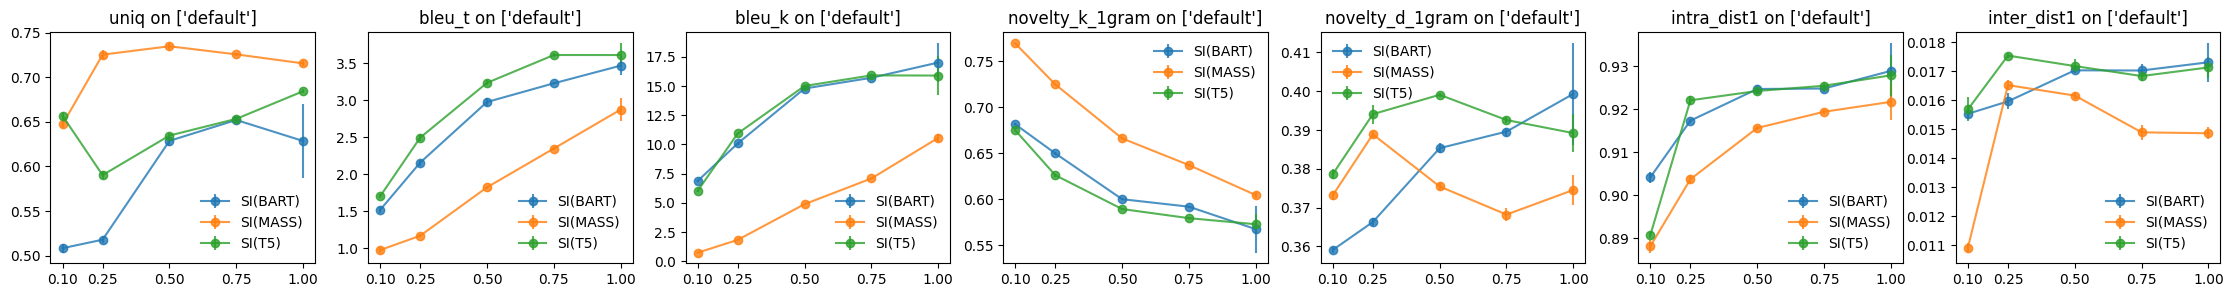

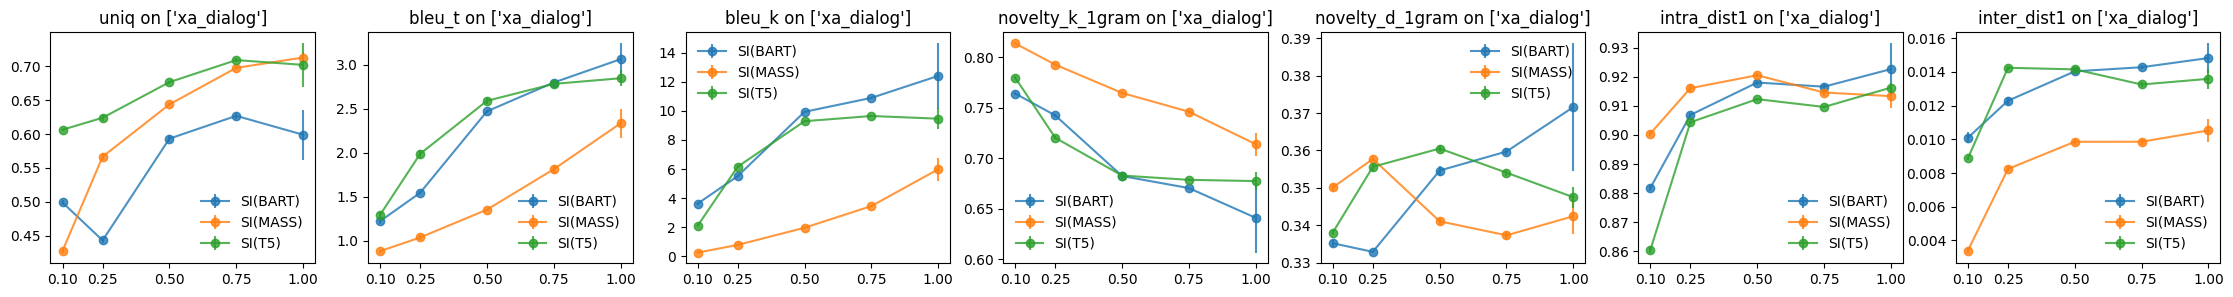

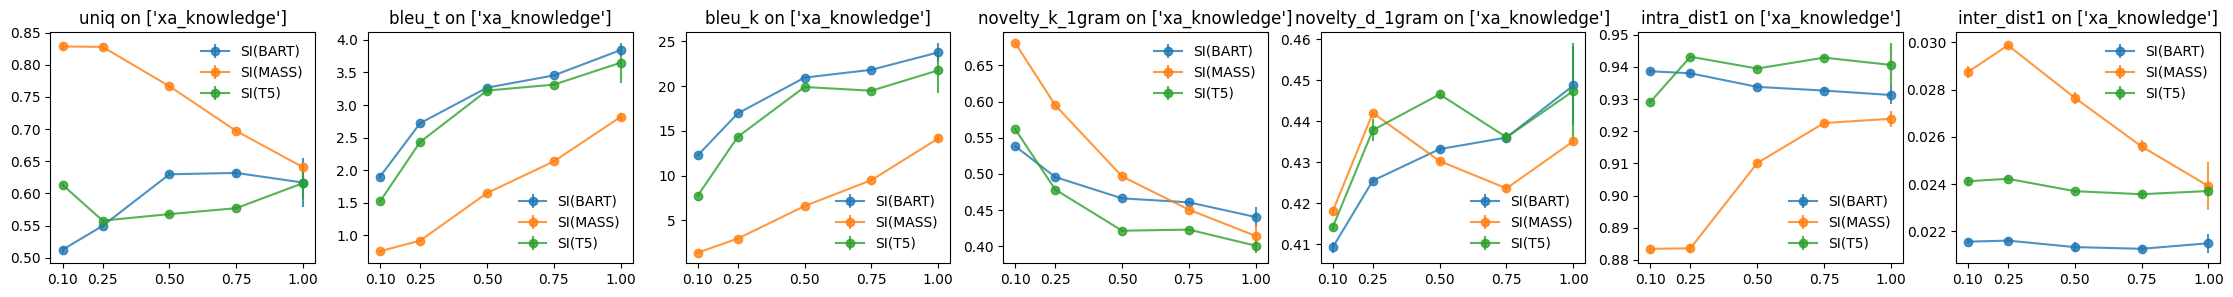

In [20]:
def plot_data_size_ablation(df, agg_ops={}, gen_settings_subset=None, models_subset=None, verbose=False):
    
    group_by_cols = ['model', 'gen_setting', 'ft_data_size']
    if verbose:
        print(f'INDEX COLUMNS: {df.index.names}')
        print(f'GROUPING BY: {group_by_cols}')
        
    dfa = df.groupby(group_by_cols, as_index=True).agg(agg_ops)
    
    # subset
    dfs = dfa.iloc[dfa.index.get_level_values('gen_setting').isin(gen_settings_subset)]
    dfs = dfs.iloc[dfs.index.get_level_values('model').isin(models_subset)]

    # initialize figure
    fig, axes = plt.subplots(nrows=1, ncols=len(agg_ops), figsize=(4*len(agg_ops), 3), sharex=True)

    if len(agg_ops) == 1: # non-iterable axes version
        for model, df in dfs.groupby(['model', 'gen_setting']):
            for k in agg_ops.keys():
                if verbose:
                    print(f'Plotting {model} {k} on axis {i} ...')

                x_vals = df.index.get_level_values('ft_data_size').values
                axes.errorbar(
                        x_vals, 
                        df[k]['mean'].values,
                        yerr=df[k]['std'].values,
                        label = model[0], # ' '.join(list(model)),
                        marker = 'o',
                        alpha=0.8,
                        linestyle = '-',
                        # fmt='-o'
                    )

                axes.set_title(f'{k} on {gen_settings_subset}')
                axes.set_xticks(x_vals)
                axes.legend(frameon=False)
    
    else:
        for model, df in dfs.groupby(['model', 'gen_setting']):
            for ax, k in zip(axes, agg_ops.keys()):
                if verbose:
                    print(f'Plotting {model} {k} on axis {i} ...')

                x_vals = df.index.get_level_values('ft_data_size').values
                ax.errorbar(
                        x_vals, 
                        df[k]['mean'].values,
                        yerr=df[k]['std'].values,
                        label = model[0], # ' '.join(list(model)),
                        marker = 'o',
                        alpha=0.8,
                        linestyle = '-',
                        # fmt='-o'
                    )

                ax.set_title(f'{k} on {gen_settings_subset}')
                ax.set_xticks(x_vals)
                ax.legend(frameon=False)

    return

print(f'Dataframe has length: {len(df)}')
# plot_data_size_ablation(df, agg_ops=agg_ops, subset=['default', 'xa_dialog', 'xa_knowledge'])
# plot_data_size_ablation(df, agg_ops={'bleu_t': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['xa_dialog'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['xa_knowledge'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'bleu_t': [np.mean, np.std], 'bleu_k': [np.mean, np.std], 'novelty_k_1gram': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])

plot_data_size_ablation(
    df, 
    agg_ops={
        'uniq': [np.mean, np.std],
        'bleu_t': [np.mean, np.std], 
        'bleu_k': [np.mean, np.std], 
        'novelty_k_1gram': [np.mean, np.std], 
        'novelty_d_1gram': [np.mean, np.std],
        'intra_dist1': [np.mean, np.std], 
        # 'intra_dist2': [np.mean, np.std],
        'inter_dist1': [np.mean, np.std],
        }, 
    gen_settings_subset=['default'], 
    models_subset=['SI(T5)','SI(MASS)','SI(BART)']
)

plot_data_size_ablation(
    df, 
    agg_ops={
        'uniq': [np.mean, np.std],
        'bleu_t': [np.mean, np.std], 
        'bleu_k': [np.mean, np.std], 
        'novelty_k_1gram': [np.mean, np.std], 
        'novelty_d_1gram': [np.mean, np.std],
        'intra_dist1': [np.mean, np.std], 
        # 'intra_dist2': [np.mean, np.std],
        'inter_dist1': [np.mean, np.std],
        }, 
    gen_settings_subset=['xa_dialog'], 
    models_subset=['SI(T5)','SI(MASS)','SI(BART)']
)

plot_data_size_ablation(
    df, 
    agg_ops={
        'uniq': [np.mean, np.std],
        'bleu_t': [np.mean, np.std], 
        'bleu_k': [np.mean, np.std], 
        'novelty_k_1gram': [np.mean, np.std], 
        'novelty_d_1gram': [np.mean, np.std],
        'intra_dist1': [np.mean, np.std], 
        # 'intra_dist2': [np.mean, np.std],
        'inter_dist1': [np.mean, np.std],
        }, 
    gen_settings_subset=['xa_knowledge'], 
    models_subset=['SI(T5)','SI(MASS)','SI(BART)']
)


280
200
min=0, max=1
saved resources/agg_results/plots/MLM-qc_sent_level.png
min=0, max=1
saved resources/agg_results/plots/MLM+DR-qc_sent_level.png
min=0, max=1
saved resources/agg_results/plots/MLM+PS+DR-qc_sent_level.png
min=0, max=1
saved resources/agg_results/plots/PS-qc_sent_level.png
min=0, max=1
saved resources/agg_results/plots/SI(BART)-qc_sent_level.png
min=0, max=1
saved resources/agg_results/plots/SI(MASS)-qc_sent_level.png
min=0, max=1
saved resources/agg_results/plots/SI(T5)-qc_sent_level.png
BASELINE model provided: MLM+PS
Plotting for models: ['MLM', 'MLM+DR', 'MLM+PS', 'MLM+PS+DR', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)']
Building multi-row (2D) 3xN plots...
Plotting MLM on axis at position 0, 0
Plotting MLM+DR on axis at position 0, 1
Plotting MLM+PS on axis at position 0, 2
min=0, max=1
Plotting MLM+PS+DR on axis at position 1, 0
Plotting PS on axis at position 1, 1
Plotting SI(BART) on axis at position 1, 2
min=0, max=1
Plotting SI(MASS) on axis at position 2, 0
Plot

/net/cephfs/data/tkew/tmp/9060466/ipykernel_23702/3867307040.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))


saved resources/agg_results/plots/SI(MASS)-bleu_k.png
min=2, max=18
saved resources/agg_results/plots/SI(T5)-bleu_k.png
BASELINE model provided: MLM+PS
Plotting for models: ['MLM', 'MLM+DR', 'MLM+PS', 'MLM+PS+DR', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)']
Building multi-row (2D) 3xN plots...
Plotting MLM on axis at position 0, 0
Plotting MLM+DR on axis at position 0, 1
Plotting MLM+PS on axis at position 0, 2
min=2, max=18
Plotting MLM+PS+DR on axis at position 1, 0
Plotting PS on axis at position 1, 1
Plotting SI(BART) on axis at position 1, 2
min=2, max=18
Plotting SI(MASS) on axis at position 2, 0
Plotting SI(T5) on axis at position 2, 1
min=2, max=18
saved resources/agg_results/plots/MLM+PS_vs_all-bleu_k.png
245
175


KeyError: 'bart_base'

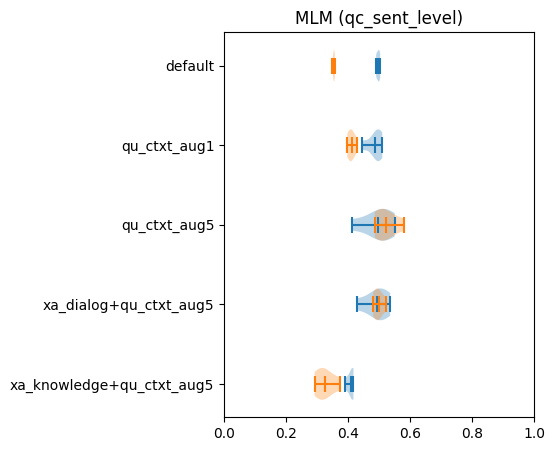

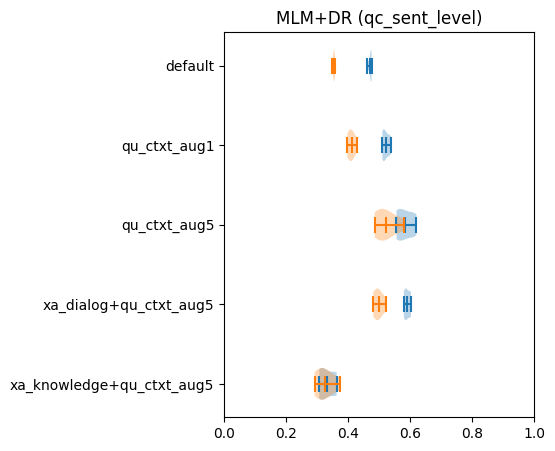

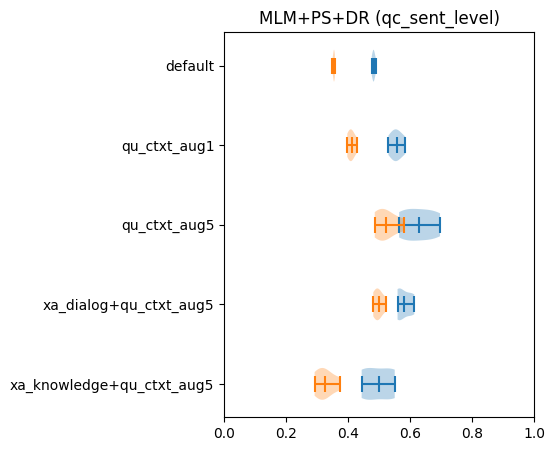

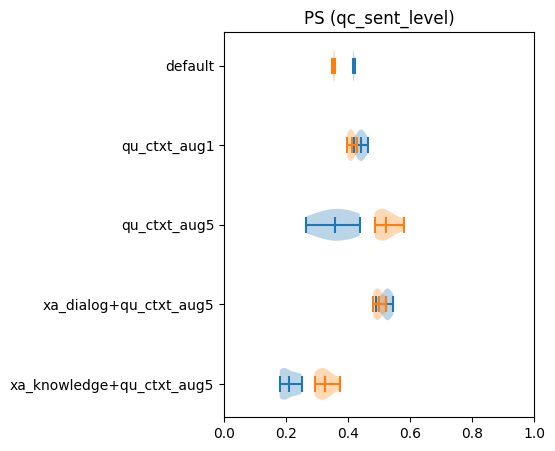

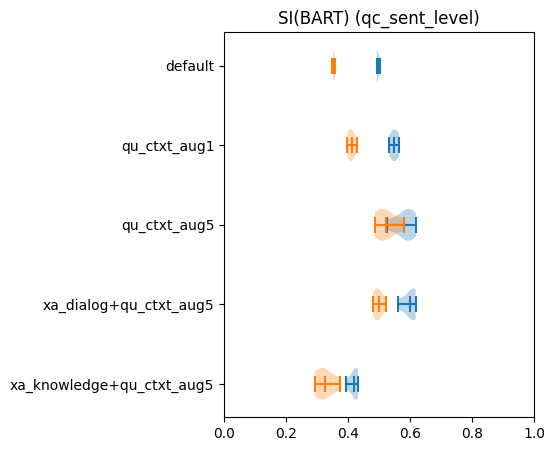

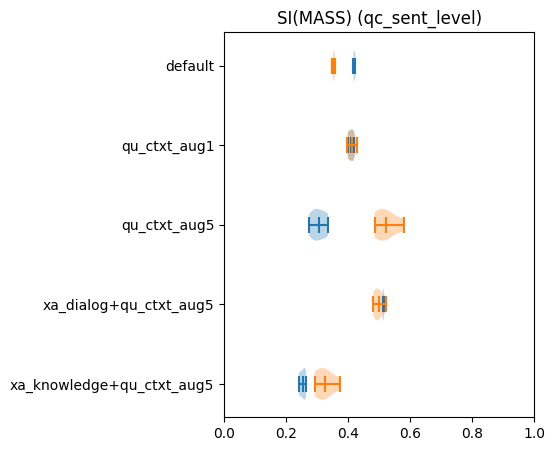

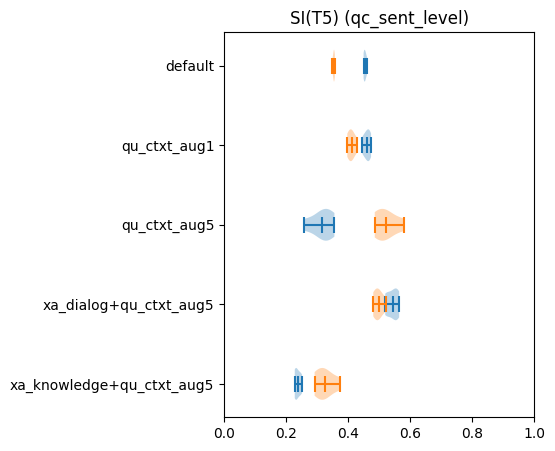

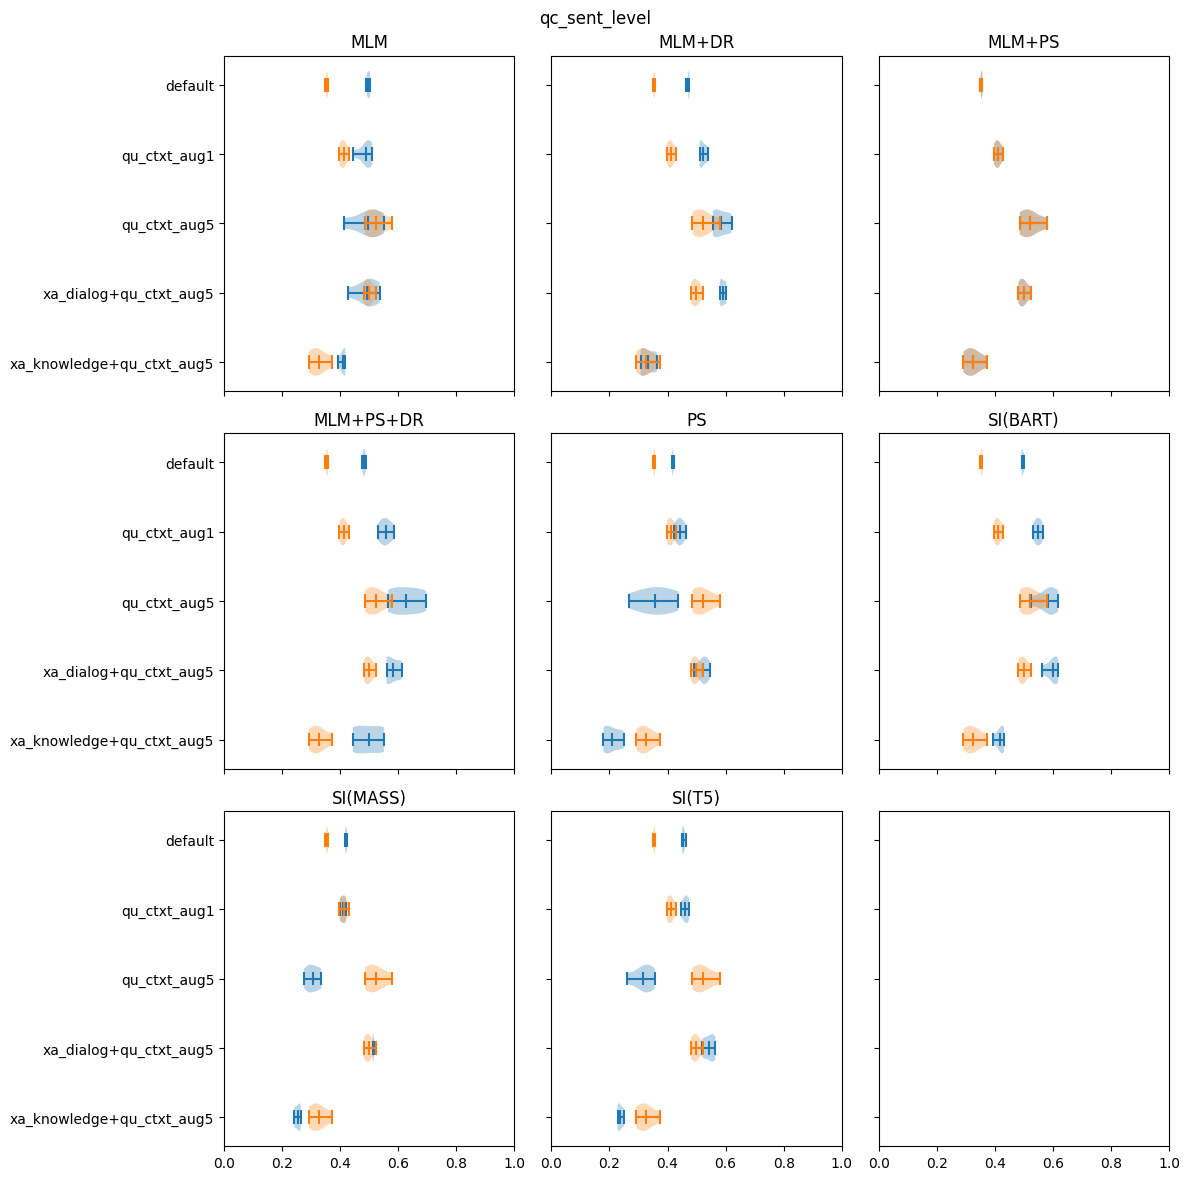

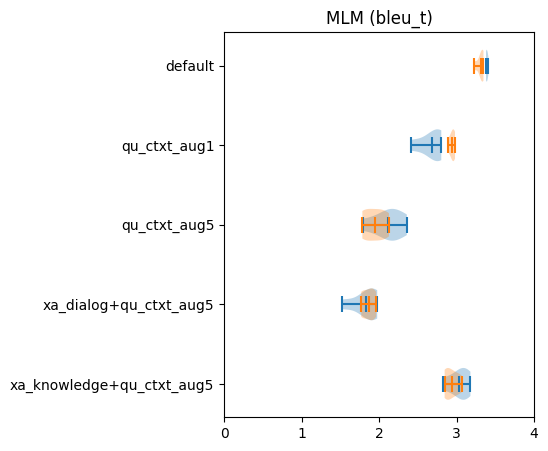

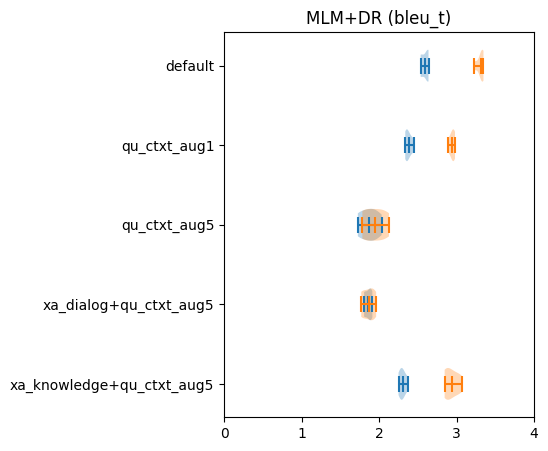

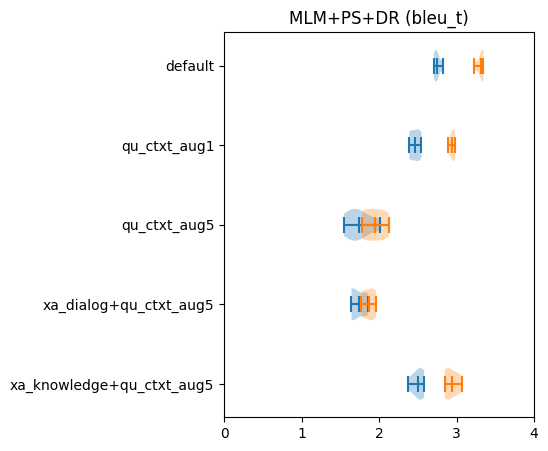

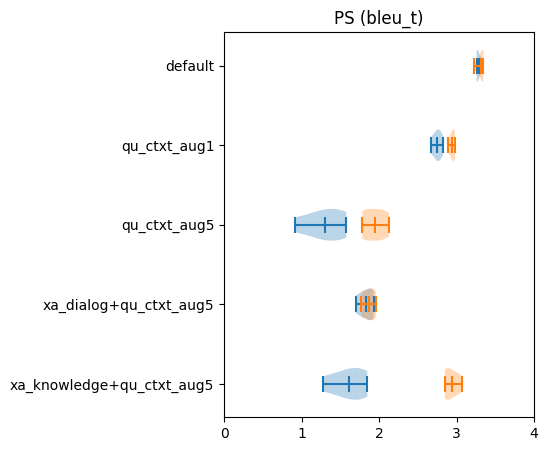

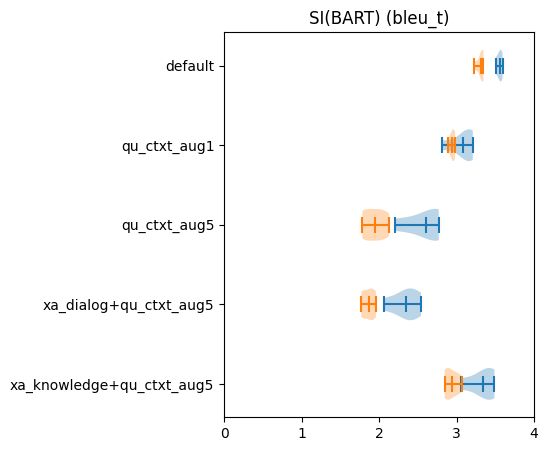

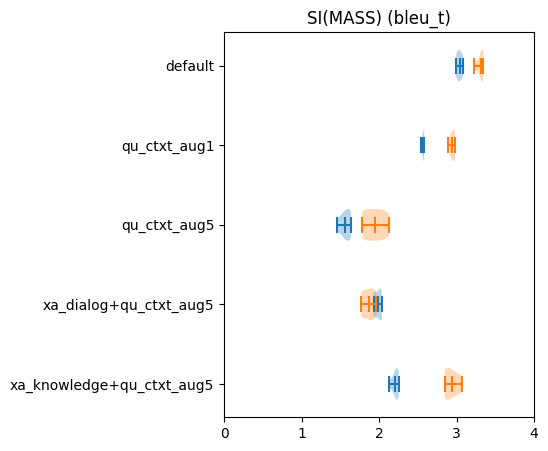

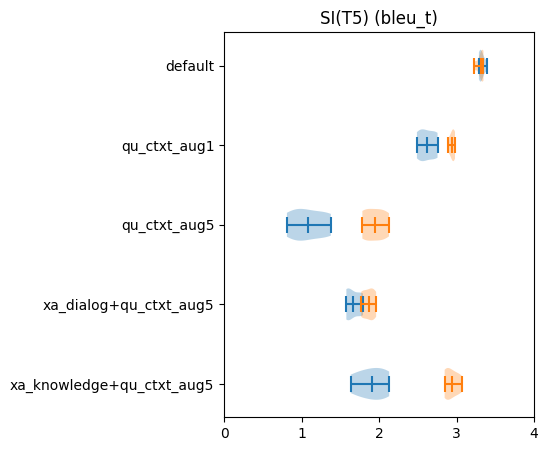

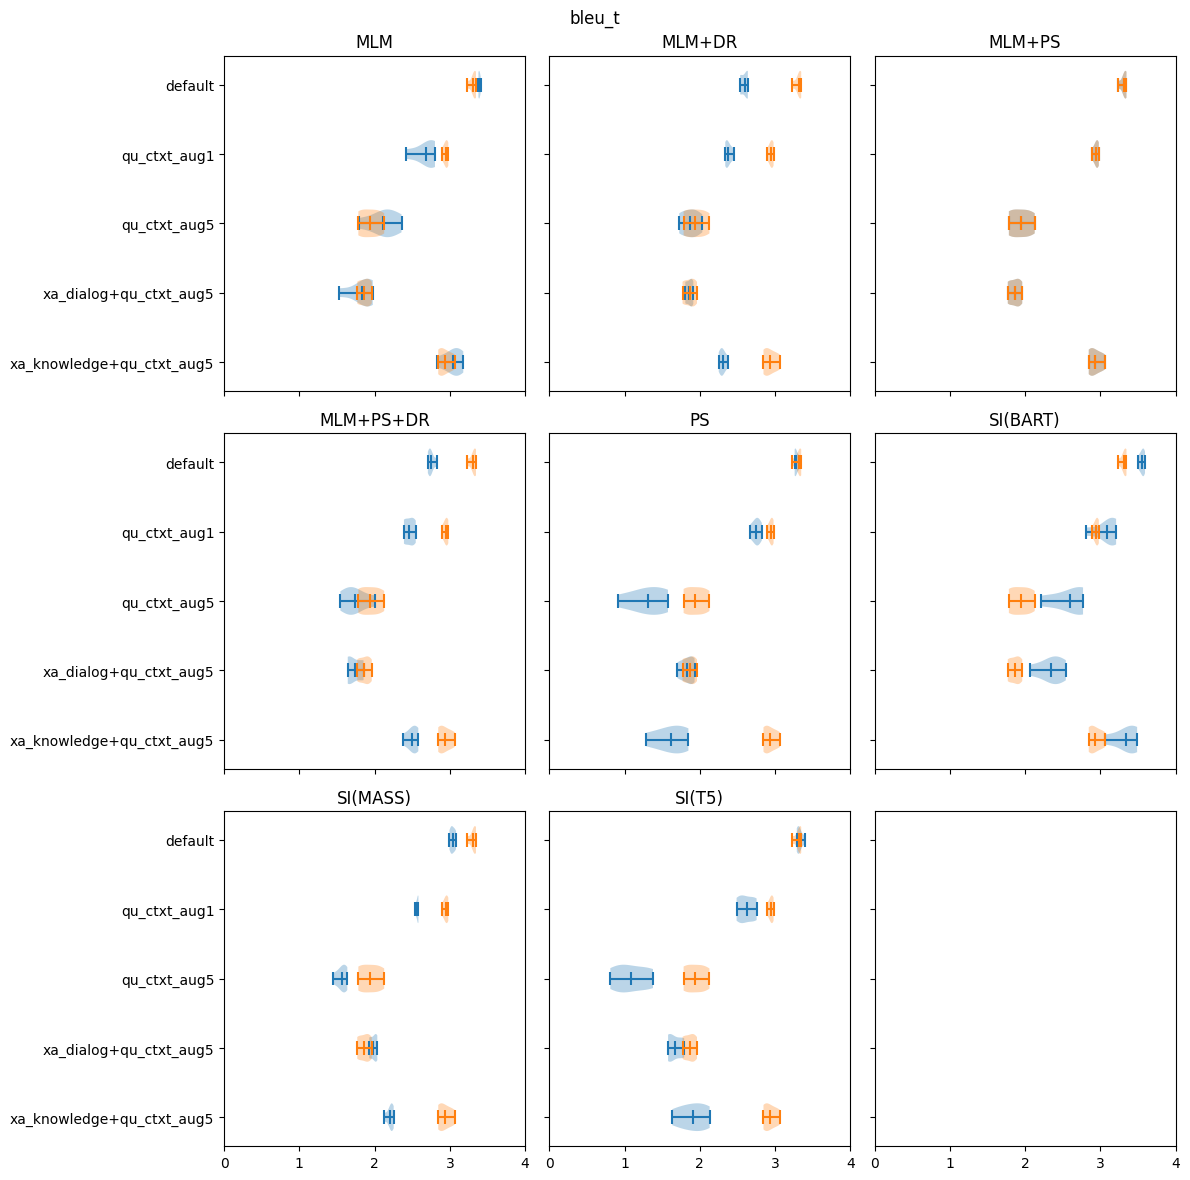

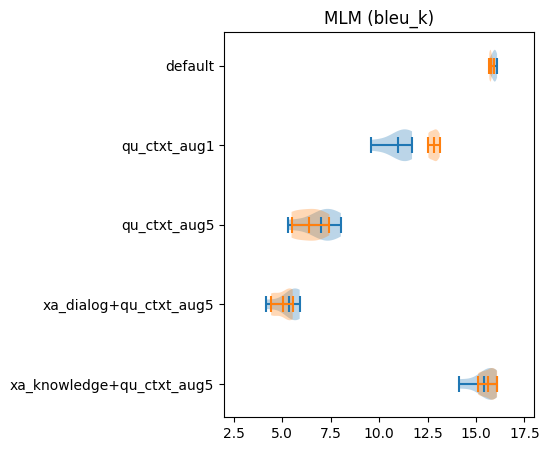

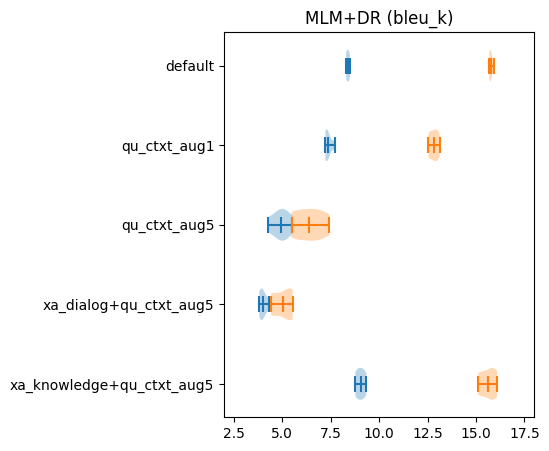

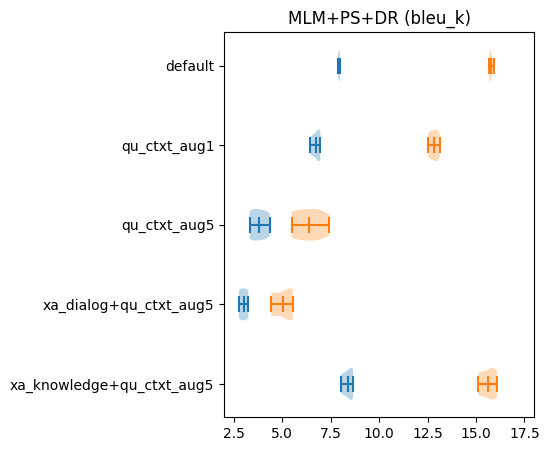

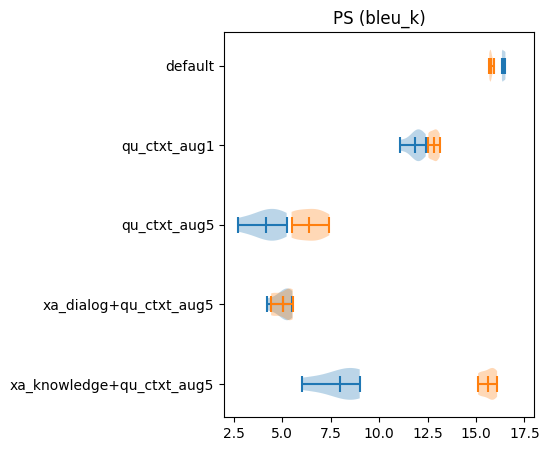

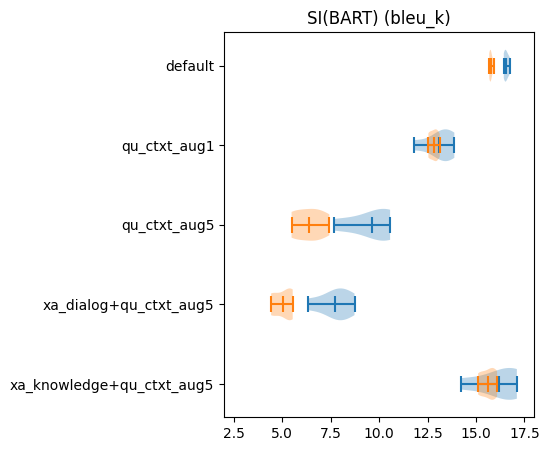

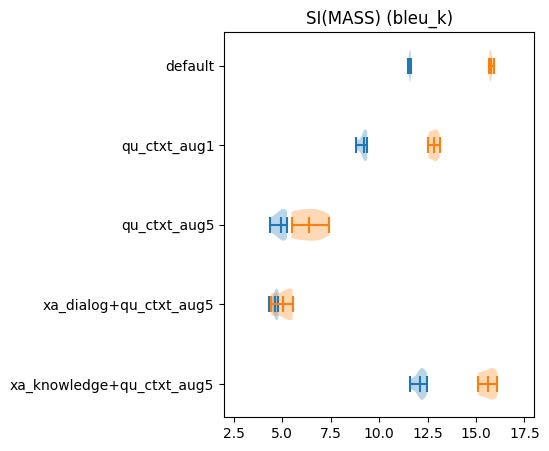

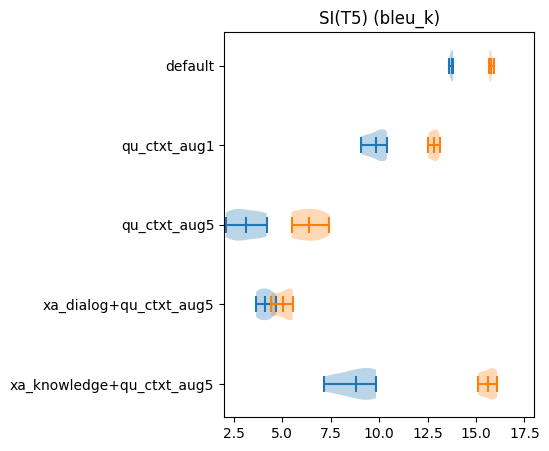

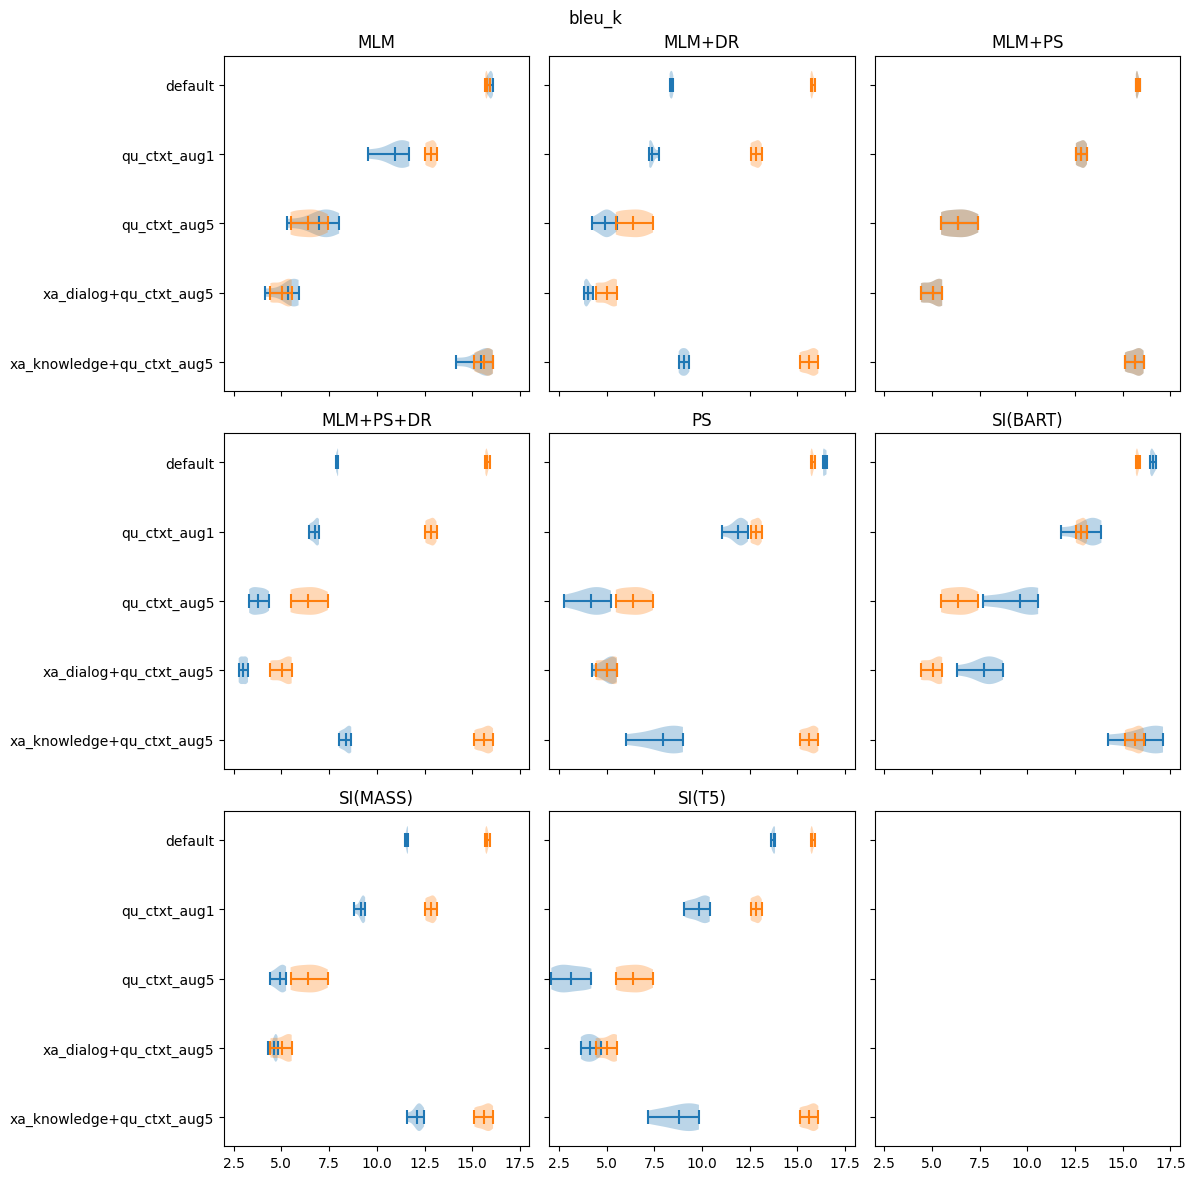

In [7]:
def parse_title(title):
    title = title.replace('bart_small', '')
    title = title.replace('(denoising)', '')
    title = title.replace('(denoising_t5)', 't5-style')
    return title

def build_violinplot(data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))

    if verbose:
        print('Data:', data)

    positions = range(1, len(data)+1)[::-1] # reveserse to have defualt at top
    labels = list(data.keys())[::-1] # reveserse to have defualt at top
    
    vp1 = ax.violinplot(
        dataset = list(data.values()),
        positions=positions,
        points=30, widths=0.4,
        showmeans=True, showextrema=True, showmedians=False,
        vert=False,
    )
    if baseline_reference_data:
        vp2 = ax.violinplot(
            dataset = list(baseline_reference_data.values()),
            positions=positions,
            points=30, widths=0.4,
            showmeans=True, showextrema=True, showmedians=False,
            vert=False,
        )

        # create legend (currently v. rough)
        # plt.legend([vp1['bodies'][0], vp2['bodies'][0]], [title, 'default'], loc=2)
        
    # make title
    ax.set_title(parse_title(title)) 
    
    # label yaxis ticks
    ax.yaxis.set_tick_params(direction='out') 
    ax.yaxis.set_ticks_position('left')
    ax.set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#     ax.set_ylabel('Generation setting')
    
    # set xaxis limits
    min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
    max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
    print(f'min={min_val}, max={max_val}')
    ax.set_xlim(min_val, max_val) #, + 0.75)

    return fig


def build_violinplot_subfig(data: Dict, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
    
    print('BASELINE model provided:', baseline_reference_key)
#     baseline_reference_data = data.pop(baseline_reference_key) if baseline_reference_key is not None else None
    baseline_reference_data = data.get(baseline_reference_key)
    model_array = list(data.keys())
    print(f'Plotting for models: {model_array}')
    
    if len(model_array) <= 3:
        # setup fig based on split arrays 1D
        
        print('Building single row plots...')
        nrows = 1
        ncols = len(model_array)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
        for i, model in enumerate(model_array):
            
            model_results = data[model]

            if baseline_reference_key is not None and baseline_reference_key != model:
                positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
                labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
                print(f'Plotting {model} on axes at position {i}')
                vp1 = axes[i].violinplot(
                    dataset = list(data[model].values()),
                    positions=positions,
                    points=30, widths=0.4,
                    showmeans=True, showextrema=True, showmedians=False,
                    vert=False,
                )
                if baseline_reference_data:
                    vp2 = axes[i].violinplot(
                        dataset = list(baseline_reference_data.values()),
                        positions=positions,
                        points=30, widths=0.4,
                        showmeans=True, showextrema=True, showmedians=False,
                        vert=False,
                    )
                # make title
                axes[i].set_title(parse_title(model))

        # label yaxis ticks
        axes[0].yaxis.set_tick_params(direction='out') 
        axes[0].yaxis.set_ticks_position('left')
        axes[0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
    #     axes[0].set_ylabel('Generation setting')

    #     # set xaxis limits
        min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
        max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
        print(f'min={min_val}, max={max_val}')
        axes[0].set_xlim(min_val, max_val) #, + 0.75)
    
    else:
        print('Building multi-row (2D) 3xN plots...')
        # setup fig based on split arrays 2D
        if len(model_array) <= 6:
            nrows = 2
        elif len(model_array) <= 9:
            nrows = 3
        elif len(model_array) <= 12:
            nrows = 4
        
        model_array = np.array_split(model_array, nrows)
        ncols = max([len(a) for a in model_array])
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
        for i, row in enumerate(model_array):
            for j, model in enumerate(row):
#                 if baseline_reference_key is not None and baseline_reference_key != model:
                positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
                labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
                print(f'Plotting {model} on axis at position {i}, {j}')
                vp1 = axes[i][j].violinplot(
                    dataset = list(data[model].values()),
                    positions=positions,
                    points=30, widths=0.4,
                    showmeans=True, showextrema=True, showmedians=False,
                    vert=False,
                )
                if baseline_reference_data:
                    vp2 = axes[i][j].violinplot(
                        dataset = list(baseline_reference_data.values()),
                        positions=positions,
                        points=30, widths=0.4,
                        showmeans=True, showextrema=True, showmedians=False,
                        vert=False,
                    )
                # make title
                axes[i][j].set_title(parse_title(model))

            # label yaxis ticks
            axes[0][0].yaxis.set_tick_params(direction='out') 
            axes[0][0].yaxis.set_ticks_position('left')
            axes[0][0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
            # axes[0][0].set_ylabel('Generation setting')

            # set xaxis limits
            min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
            max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
            print(f'min={min_val}, max={max_val}')
            axes[0][0].set_xlim(min_val, max_val) #, + 0.75)

    plt.suptitle(target_metric)
    plt.tight_layout()

    return fig

def build_violin_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

    # collect all the data for the relevant target metric first to set min and max vals for all plots
    data = {}
    for i, (model, dfx) in enumerate(df.groupby(level=1)):
        model_results = {}
        for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=2)):
            metric_scores = dfx[target_metric].values
            if min(metric_scores) < min_val:
                min_val = min(metric_scores)
            if max(metric_scores) > max_val:
                max_val = max(metric_scores)
            model_results[gen_setting] = metric_scores
        data[model] = model_results

    if verbose:
        print('Data:')
        print(data)
        
    baseline_reference_data = data[baseline_reference_key] if baseline_reference_key is not None else None
    
    # make violins for each model
    for model, results in data.items():
        if baseline_reference_key and baseline_reference_key != model:
            fig = build_violinplot(results, f'{model} ({target_metric})', baseline_reference_data, min_val, max_val, verbose=verbose)
            if save:
                outpath = str(plot_path / f'{model}-{target_metric}.png')
                fig.savefig(outpath, dpi='figure', bbox_inches='tight')
                print(f'saved {outpath}')
    
    # make a subfig for all models
    fig = build_violinplot_subfig(data, target_metric, baseline_reference_key, min_val, max_val, verbose=verbose)
    if save:
        outpath = str(plot_path / f'{baseline_reference_key}_vs_all-{target_metric}.png')
        fig.savefig(outpath, dpi='figure', bbox_inches='tight')
        print(f'saved {outpath}')

    
    return


# compare bart_base with bart_small
# dff = df[df.index.isin(['bart_base', 'bart_small(denoising)'], level=0)]
# build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)

# # compare all bart_small models
dff = df.iloc[~df.index.get_level_values(1).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
print(len(dff))
dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=2, axis=0)
print(len(dff))
build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='MLM+PS', save=True, verbose=False)
build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='MLM+PS', save=True, verbose=False)
build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='MLM+PS', save=True, verbose=False)

# # # compare off-the-shelf fine-tuned models
dff = df.iloc[df.index.get_level_values(1).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
print(len(dff))
dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=2, axis=0)
print(len(dff))
build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)
build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='bart_base', save=True, verbose=False)
build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='bart_base', save=True, verbose=False)



In [40]:
# import matplotlib.colors as mcolors
# colors = [mcolors.to_hex(plt.cm.tab20(i)) for i in range(20)]
# # patterns = ['', '\\', '+', 'x', '.', '*', 'o', 'O',]
# hpatterns = ['', '\\', '\\\\', '/', '//', '|', '||'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]
# vpatterns = ['', '\\', '\\\\', '/', '//', '-', '--'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]

# def build_bar_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', horizontal: bool = False, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

#     # collect all the data for the relevant target metric first to set min and max vals for all plots
#     data = {}
#     for i, (model, dfx) in enumerate(df.groupby(level=0)):
#         model_results = {}
#         for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=1)):
#             metric_scores = dfx[target_metric].values
#             if min(metric_scores) < min_val:
#                 min_val = min(metric_scores)
#             if max(metric_scores) > max_val:
#                 max_val = max(metric_scores)
#             model_results[gen_setting] = metric_scores
#         data[model] = model_results

#     build_bar(data, horizontal=horizontal, verbose=verbose)
    
#     return


# def build_bar(data: Dict, horizontal: bool = True, verbose: bool = True):

#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#     positions = []
#     means = []
#     stds = []
#     bar_colors = []
#     bar_patterns = []
#     labels = []
    
#     pos = 0
#     for i, (model, gen_settings) in enumerate(data.items()):
#         # TODO make groups for colors and build legend
#         # https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
# #                 group = {model: {}}
#         for j, (gen_setting, scores) in enumerate(gen_settings.items()):

#             labels.append(f'{model} {gen_setting}')
            
#             if not horizontal:
#                 ax.bar(
#                     x = pos,
#                     height = scores.mean(),
#                     yerr=scores.std(), 
#                     color=colors[i],
#                     hatch=vpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             else:
#                 ax.barh(
#                     y = pos,
#                     width = scores.mean(),
#                     xerr=scores.std(), 
#                     color=colors[i],
#                     hatch=hpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             pos += 1 # incrememt pos for next bar
        
#         if not horizontal:
#             ax.set_xticks(np.arange(len(labels)), labels=labels, rotation=45)
#         else:
#             ax.set_yticks(np.arange(len(labels)), labels=labels)
# #         ax.legend()
        
# dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)

# # dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# # build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)


